In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib



  0%|          | 0/150 [00:00<?, ?it/s]

Training 101
torch.Size([1, 2, 59, 105]) torch.Size([1, 2, 88, 157]) torch.Size([1, 2, 118, 210])
cost -0.020654158666729927


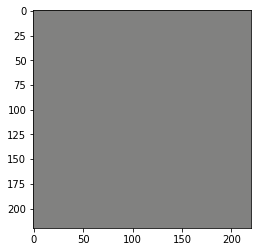


  7%|▋         | 10/150 [00:02<00:31,  4.41it/s]

cost -0.020936651155352592


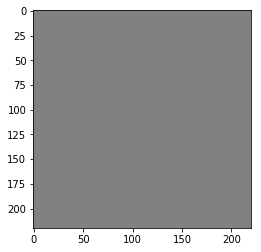


 13%|█▎        | 20/150 [00:04<00:29,  4.47it/s]

cost -0.021220006048679352


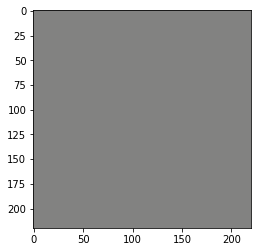


 20%|██        | 30/150 [00:06<00:26,  4.46it/s]

cost -0.021615855395793915


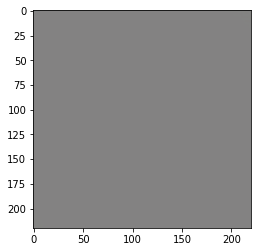


 27%|██▋       | 40/150 [00:09<00:24,  4.47it/s]

cost -0.021985268220305443


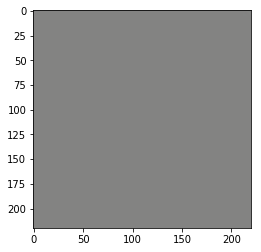


 33%|███▎      | 50/150 [00:11<00:22,  4.46it/s]

cost -0.02259492501616478


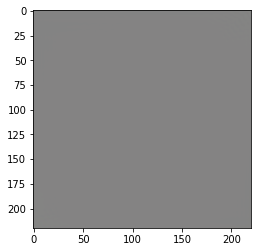


 40%|████      | 60/150 [00:13<00:20,  4.46it/s]

cost -0.022834278643131256


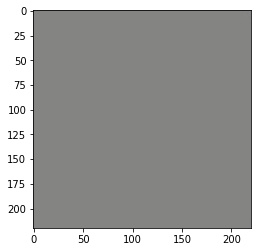


 47%|████▋     | 70/150 [00:16<00:17,  4.46it/s]

cost -0.022905990481376648


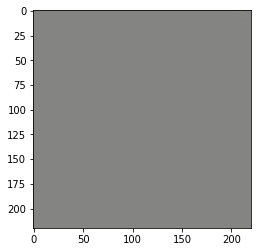


 53%|█████▎    | 80/150 [00:18<00:15,  4.46it/s]

cost -0.02349017560482025


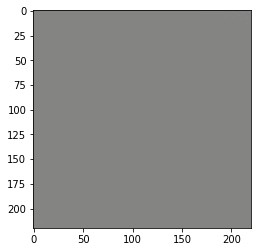


 60%|██████    | 90/150 [00:20<00:13,  4.49it/s]

cost -0.02360488660633564


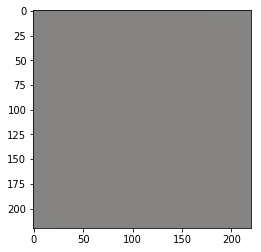


 67%|██████▋   | 100/150 [00:23<00:11,  4.45it/s]

cost -0.023238521069288254


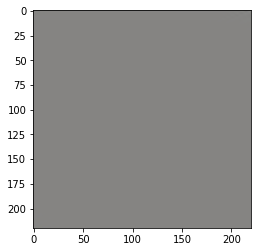


 73%|███████▎  | 110/150 [00:25<00:08,  4.45it/s]

cost -0.023708580061793327


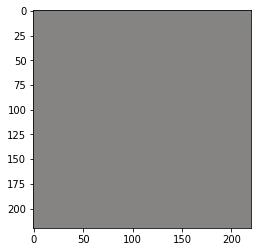


 80%|████████  | 120/150 [00:27<00:06,  4.45it/s]

cost -0.024260587990283966


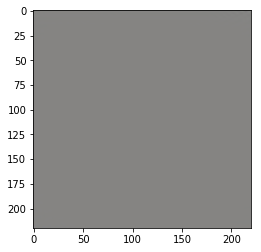


 81%|████████  | 121/150 [00:28<00:09,  3.19it/s]

KeyboardInterrupt: 

In [64]:
import time
from skimage.io import imsave
from dreamz.utils import get_latest_filename, tch_im_to_np
from dreamz.cppn import get_xy_mesh, CPPNNet
from dreamz.render import train_visualiser
from dreamz.torch_utils import Lambda, adjust_learning_rate
from dreamz.cppn import composite_activation
import torch
from torch import nn
from torchvision import models
from torch.nn import functional as F
from torch import optim
import numpy as np


class Net(nn.Module):
    def __init__(self, base_model, reps=2, output_channels=3):
        super(Net, self).__init__()
        self.base_model = base_model

        s_in = self.base_model.output_channels
        s = 10

        self.conv1 = self.get_group_of_layers(reps, s_in, s)
        self.conv2 = self.get_group_of_layers(reps - 1, s * 2, s)
        self.conv3 = nn.Conv2d(s * 2, output_channels, 3)
        self.final_act = nn.Sigmoid()

    def get_group_of_layers(self, reps, s0, s, k=3):
        this = []
        for i in range(reps):
            this += [nn.Conv2d(s0, s, k)]
            nn.init.normal_(
                this[-1].weight,
                std=np.sqrt(1 / (s0 * (k ** 2)))
            )
#             this += [nn.ReLU6()]
            this += [Lambda(composite_activation)]
            s0 = s * 2
        return nn.Sequential(*this)

    def forward(self, x):
        x = self.base_model.layers(x)
        x = self.conv1(x)
        x = F.upsample_bilinear(x, scale_factor=2)
        x = self.conv2(x)
        x = torch.stack([x, torch.zeros_like(x)], -1)
        x = torch.ifft(x, 3, normalized=False)[..., 0]
        x = F.upsample_bilinear(x, scale_factor=2)
        x = self.conv3(x)
        x = self.final_act(x)
        return x[:, :, 3:-3, 3:-3]


def train(size, widths, imagenet_model, chan_to_opt, log_interval):
    base = CPPNNet(widths)
    viz = Net(base, reps=1).to(device)
    viz = nn.DataParallel(viz)
    mean = torch.FloatTensor([0.485, 0.456, 0.406]).to(device).view(1, 3, 1, 1)
    std = torch.FloatTensor([0.229, 0.224, 0.225]).to(device).view(1, 3, 1, 1)

    def imgnet_objective(output, _):
        r = imagenet_model((output - mean) / std)
    #     return torch.mean((r - targ) ** 2)
        return -r[:, chan_to_opt].mean()

    xy = get_xy_mesh(size).to(device)
    xy2 = get_xy_mesh([int(i * 1.5) for i in size]).to(device)
    xy4 = get_xy_mesh([int(i * 2.0
                          ) for i in size]).to(device)
    print(xy.shape, xy2.shape, xy4.shape)

    def im_gen_fn(pct_done=0.0, num=64):
        xy_crop = []
        h, w = size
        for i in range(num):
            r = np.random.rand()
            if i == 0:
                x0, x1 = 30, 30 + h
                xy_crop.append(xy[:, :, :, x0:x1])
            elif r < 0.2:
                x0 = np.random.choice([0, w - h])
                x1 = x0 + h
                xy_crop.append(xy[:, :, :, x0:x1])
            elif r < 0.6:
                x0 = np.random.randint(0, xy2.shape[3] - h)
                x1 = x0 + h
                y0 = np.random.randint(0, xy2.shape[2] - h)
                y1 = y0 + h
                xy_crop.append(xy2[:, :, y0:y1, x0:x1])
            else:
                x0 = np.random.randint(0, xy4.shape[3] - h)
                x1 = x0 + h
                y0 = np.random.randint(0, xy4.shape[2] - h)
                y1 = y0 + h
                xy_crop.append(xy4[:, :, y0:y1, x0:x1])
                
        xy_crop = torch.cat(xy_crop, 0)
        im = viz(xy_crop)
        return im, None

    opt = optim.Adam(viz.parameters(), lr=0.001)
    train_visualiser(imgnet_objective, im_gen_fn, opt, iters=150, log_interval=log_interval)
    adjust_learning_rate(opt, 0.1)
    train_visualiser(imgnet_objective, im_gen_fn, opt, iters=50, log_interval=log_interval)
    return viz


def get_imagenet_model():
    model = models.resnet50(pretrained=True)
    model = nn.Sequential(*(
        [i for i in model.children()][:-3] + [
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            Lambda(lambda x: x[:, :, 0, 0])]))
    return model.eval()


device = 'cuda'
ims_savedir = '../data/output_ims3/'
widths = [24] * 6
size = [59, 105]

imagenet_model = get_imagenet_model().to(device)
imagenet_model = nn.DataParallel(imagenet_model)

chan_to_opt = 101
log_interval = 10

now = time.time()
print('Training {}'.format(chan_to_opt))
viz = train(size, widths, imagenet_model, chan_to_opt, log_interval)
print('Took {} seconds'.format(time.time() - now))

In [65]:
now = time.time()
print('Saving {}'.format(chan_to_opt))
xy_big = get_xy_mesh([277, 502]).to(device)
res = viz(xy_big)
# imsave(get_latest_filename(ims_savedir), tch_im_to_np(res))
print('Took {} seconds'.format(time.time() - now))


Saving 101
Took 0.020512819290161133 seconds


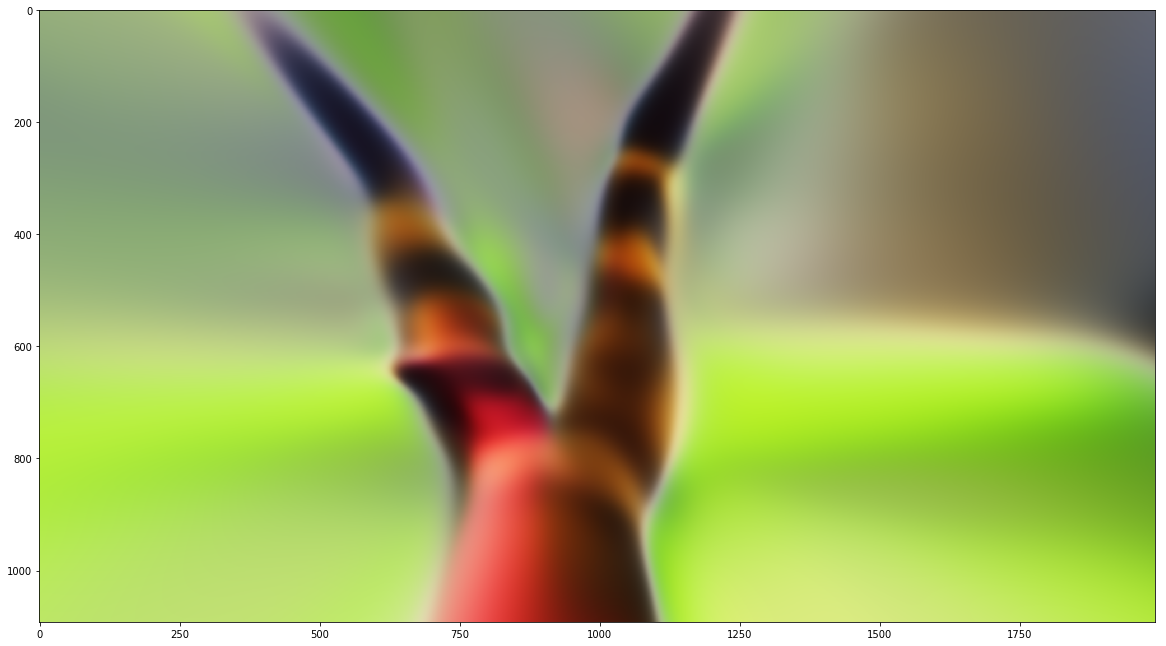

In [66]:
plt.figure(figsize=[20]*2)
plt.imshow(tch_im_to_np(res))